# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [1]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display
import shap

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non

### On reprend les éléments du notebook de l'étape 1

In [2]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape1_clean.csv")

# Partie 5 - Optimisez et interprétez le comportement du modèle

### Recommandation 1 - Reprenez les mêmes principes que le projet 3 (si vous suivez ce parcours dans sa totalité) pour le fine-tuning.
* Afin de trouver les meilleurs hyperparamètres de notre modèle sélectionné, CatBoost, nous utilisons un GridSearchCV pour les rechercher.

#### Récupération de notre séparation X et y et de nos features

In [7]:
# Transformation + séparation X et y dans utils.py
X, y = prepare_xy(donnees_modelisation, target_col="a_quitte_l_entreprise")
features_a_scaler, features_encodees = scaler_ou_non()

# Transformation + séparation X et y dans utils.py
X, y = prepare_xy(donnees_modelisation, target_col="a_quitte_l_entreprise")
features_a_scaler, features_encodees = scaler_ou_non()

target_col = "a_quitte_l_entreprise"

train_df = pd.read_csv("../Data/Processed/train_data_df.csv")
test_df  = pd.read_csv("../Data/Processed/test_data_df.csv")

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

#### Recherche des hyperparamètres

In [8]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(),features_a_scaler),
        ('cat','passthrough',features_encodees)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',CatBoostClassifier(random_state = 42, verbose=0))
])
# Enregistrement des paramètres
param_grid = {
    'model__iterations' : [100, 200, 300, 500],
    'model__depth' : [2, 3, 4],
    'model__learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05],
    'model__class_weights' : [[1, 3], [1, 5], [1, 7]],
}
# Mise en place du GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    scoring='recall', #choix du recall par logique avec l'étape précédente
    verbose = 0
)
# Entraînement du modèle
grid_search.fit(X_train, y_train)
# J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur recall :", grid_search.best_score_)

Meilleurs paramètres : {'model__class_weights': [1, 7], 'model__depth': 2, 'model__iterations': 100, 'model__learning_rate': 0.01}
Meilleur recall : 0.841683201058201


#### L'utilisation de GridSearchCV nous donne des hyperparamètres qui améliorent le racall de notre modèle par rapport à l'étape 4.

Les meilleurs paramètres sont :
* 'model__class_weights': [1, 7]
* 'model__depth': 2
* 'model__iterations': 100
* 'model__learning_rate': 0.01

### On peut désormais lancer une validation croisée avec nos nouveaux hyperparamètres optimisés 

In [9]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        iterations=100, #nombre d’arbres boostés
        depth=2, # profondeur des arbres
        learning_rate=0.01, # vitesse d’apprentissage
        class_weights=[1, 7], # pondération des classes
        random_state=42,
        verbose=0
    ))])

# Validation croisée sur l'entraînement (stockage moyennes/écarts-types)
scoring = ['precision', 'recall', 'f1', 'average_precision', 'balanced_accuracy']  # average_precision = PR AUC
cv = StratifiedKFold(n_splits=3)
cv_results = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1)

print("=== Résultats CV (train vs val) ===")
for metric in scoring:
    tr = cv_results[f"train_{metric}"]
    te = cv_results[f"test_{metric}"]
    print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

=== Résultats CV (train vs val) ===
precision         : train 0.266 ± 0.003 vs val 0.243 ± 0.008
recall            : train 0.892 ± 0.017 vs val 0.842 ± 0.001
f1                : train 0.410 ± 0.005 vs val 0.378 ± 0.009
average_precision : train 0.603 ± 0.030 vs val 0.495 ± 0.030
balanced_accuracy : train 0.709 ± 0.007 vs val 0.669 ± 0.009


* On améliore notre recall par rapport à l'ancienne validation croisée en passant de 0.663 à 0.842

In [12]:
# On entrâine le modèle
pipeline.fit(X_train, y_train)
# Évaluation TEST
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print("=== Classification Report - TRAIN ===")
print(classification_report(y_train, y_pred_train, digits=3))
print("=== Classification Report - TEST ===")
print(classification_report(y_test, y_pred_test, digits=3))

=== Classification Report - TRAIN ===
              precision    recall  f1-score   support

           0      0.964     0.487     0.647       986
           1      0.254     0.905     0.396       190

    accuracy                          0.554      1176
   macro avg      0.609     0.696     0.522      1176
weighted avg      0.849     0.554     0.606      1176

=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.950     0.466     0.625       247
           1      0.237     0.872     0.373        47

    accuracy                          0.531       294
   macro avg      0.594     0.669     0.499       294
weighted avg      0.836     0.531     0.585       294



* On obtient un très bon recall de 0.872 au détriment d'une précision de 0.237.

In [13]:
cm_test  = confusion_matrix(y_test, y_pred_test)
print("=== Matrice de confusion - TEST ===")
print(cm_test)

=== Matrice de confusion - TEST ===
[[115 132]
 [  6  41]]


#### On voit avec la matrice de confusion que nous captons une bonne partie des départs des salariés. Le fait d'avoir mit l'accent sur le recall nous permet de pouvoir répondre au mieux à la mission que nous a confié les RH.

### Recommandation 2 : Commencez d’abord par la feature importance globale, moins complexe, avant de passer à la locale.

### Feature importance globale de notre modèle

In [10]:
# Récupération du modèle CatBoost à l'intérieur du pipeline
cat = best_model.named_steps['model']

# Récupération des noms de features après préprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Importances globales
importances = cat.get_feature_importance()

# Mettre en DataFrame pour plus de lisibilité
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(fi_df.head(15))  # top 15

                                           Feature  Importance
1                    num__annees_dans_l_entreprise   20.867815
17                      cat__heure_supplementaires   19.773379
15                         num__pee_par_anciennete   17.083204
0                              num__revenu_mensuel   12.902808
13                         num__score_satisfaction    8.918210
20                                cat__tranche_age    7.227061
18                      cat__frequence_deplacement    1.974946
29                           cat__poste_Consultant    1.509712
3                  num__note_evaluation_precedente    1.257973
6   num__satisfaction_employee_equilibre_pro_perso    1.255715
30                   cat__poste_DirecteurTechnique    0.963200
4        num__satisfaction_employee_nature_travail    0.955120
9                   num__distance_domicile_travail    0.806846
31                              cat__poste_Manager    0.725859
32               cat__poste_ReprésentantCommercial    0

#### Graphique de la feature importance

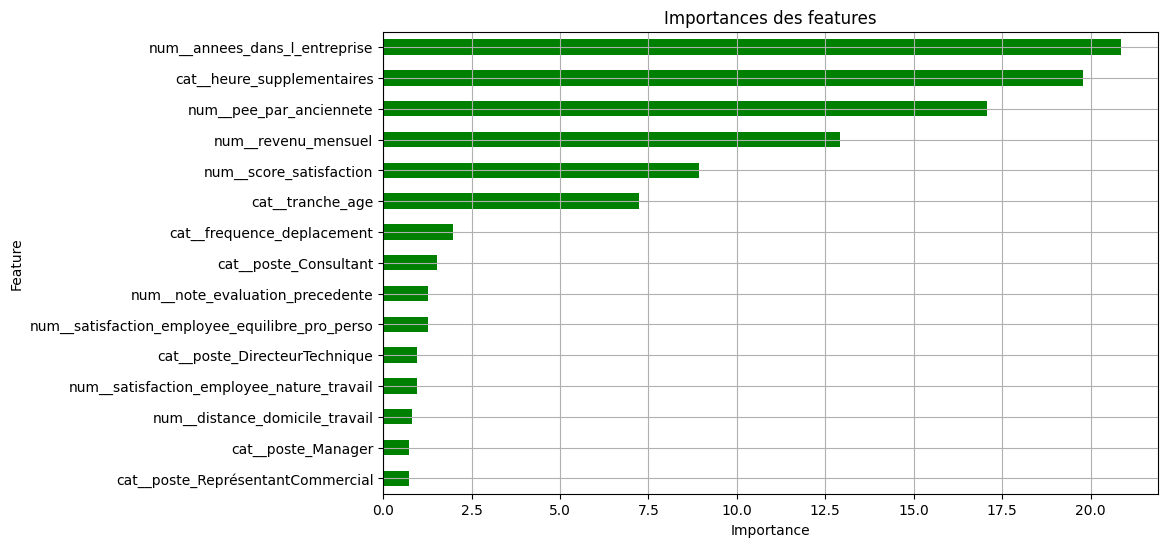

In [11]:
top_features = fi_df.nlargest(15, 'Importance')
top_features.sort_values(by="Importance", ascending=True).plot(
    x="Feature",
    y="Importance",
    kind="barh",
    legend=False,
    figsize=(10,6),
    color="green"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importances des features")
plt.grid()
plt.show()

On peut identifier 6 variables importantes et qui dominent les autres features :

- cat__heure_supplementaires
- num__annees_dans_l_entreprise
- num__revenu_mensuel
- num__pee_par_anciennete
- cat__tranche_age
- num__score_satisfaction

### Recommandation 3 : Comparez plusieurs méthodes de feature importance globale et analysez leur points de convergence et de divergence. Vous pouvez comparer à minima la Permutation Importance de sklearn avec le Beeswarm Plot du package SHAP. Si votre modèle optimisé est à base d’arbre, vous pouvez également inclure sa feature importance native dans la comparaison.

### Permutation importance

* La permutation importance va nous permettre également de mesurer l'importance des variables mais d'une façon un peu différente. Cette technique consiste à changer de manière aléatoire les données d'une variable pour en calculer son impact sur le modèle.

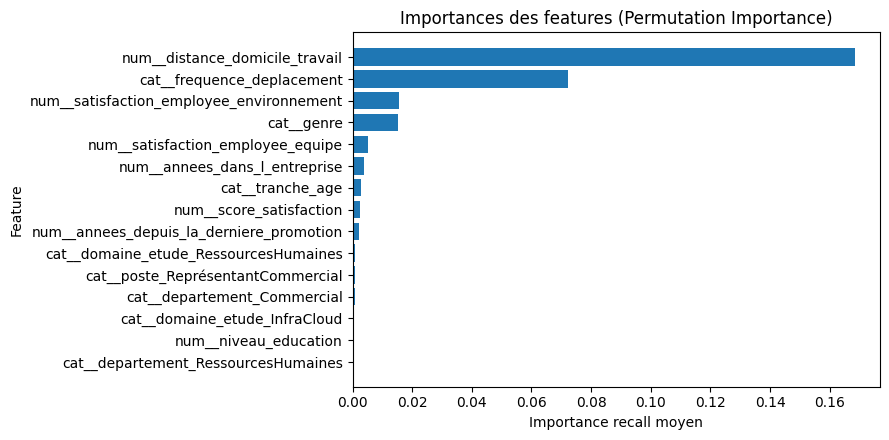


=== Permutation importance — Top 15 ===
                                 feature  importance_mean  importance_std
          num__distance_domicile_travail         0.168425        0.029873
              cat__frequence_deplacement         0.072176        0.038281
num__satisfaction_employee_environnement         0.015676        0.042017
                              cat__genre         0.015168        0.013085
       num__satisfaction_employee_equipe         0.005311        0.004171
           num__annees_dans_l_entreprise         0.003782        0.032584
                        cat__tranche_age         0.002725        0.019496
                 num__score_satisfaction         0.002342        0.006033
num__annees_depuis_la_derniere_promotion         0.002022        0.003099
   cat__domaine_etude_RessourcesHumaines         0.000819        0.001873
       cat__poste_ReprésentantCommercial         0.000780        0.001450
             cat__departement_Commercial         0.000759        0.0025

In [14]:
# Ajout de la permutation_importance
perm = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    scoring='average_precision',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
# Création d'un DataFrame des importances
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
perm_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    })
    .sort_values('importance_mean', ascending=False)
)
# Top 15 pour lisibilité
topk = 15
top_df = perm_df.head(topk).iloc[::-1] 

# Graphique
plt.figure(figsize=(9, 4.5))
plt.barh(top_df['feature'], top_df['importance_mean'])
plt.title("Importances des features (Permutation Importance)")
plt.xlabel("Importance recall moyen") 
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Afficher le tableau Top 15
print("\n=== Permutation importance — Top 15 ===")
print(top_df.iloc[::-1].to_string(index=False)) 

* Concentration de la permutation importance (avec comme scoring l'average_precision) dans la varibale num__distance_domicile_travail et cat__frequence_deplacement. Ces 2 variables ne se retrouvent pas dans le top 5 de la feature importance.

### Recommandation 4 : Si vous utilisez un modèle à base d’arbre, privilégiez l’utilisation du TreeExplainer du package SHAP. Sinon, vous pouvez utiliser le KernelExplainer, plus généraliste.

### Continuons l'analyse de manière globale avec le Beeswarm de l'analyse de SHAP

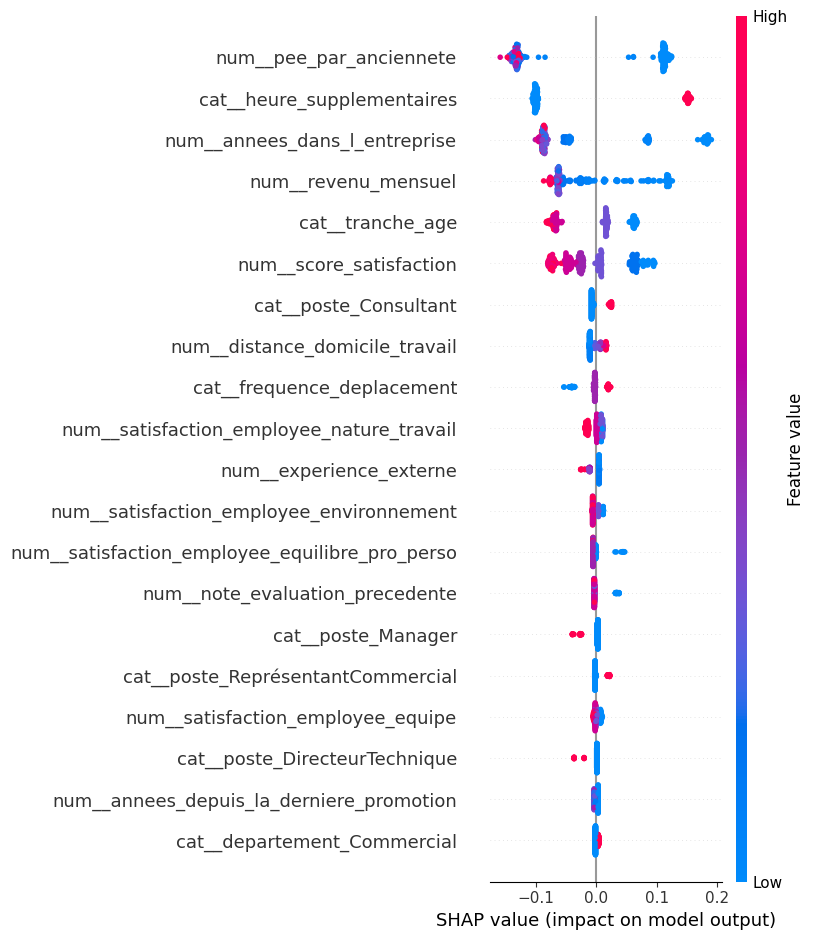

In [15]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Graphique de beeswarm
shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


#### On peut noter ici plusieurs choses intéressantes :
* On voit que les salariés avec un revenu mensuel bas ont une plus grande probabilité de partir alors que les salaires les plus hauts ont une probabilité plus faible de départ. Notre intuition dans les étapes précédentes suit cette logique.
* On voit que les salariés qui réalisent des heures supplémentaires ont une probabilité plus grande de partir que ceux qui n'en font pas.
* Plus de probabilité de départ pour des personnes arrivés il n'y a pas longtemps dans l'entreprise. Ce qui explique également le nombre de PEE plus faible qui indique un score de proba vers le départ.
* Plus de départs possibles dans une tranche d'âge plus jeune


### Recommandation 5 : Assurez-vous de bien comprendre le sens des Shapley values en utilisant la fonction shap.plots.scatter() et son argument “color”.

#### Pour la variable revenu_mensuel

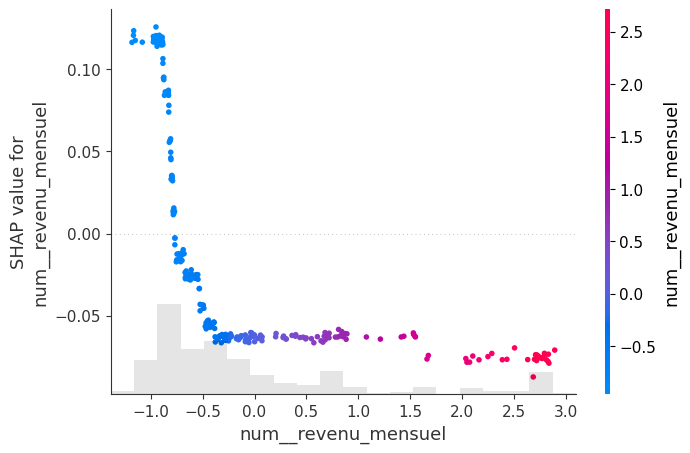

In [16]:
# Données transformées + noms
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names)

# Explainer + Explanation object
cat = best_model.named_steps['model']
explainer = shap.TreeExplainer(cat)
sv = explainer(X_df, check_additivity=False) 

# Scatter
shap.plots.scatter(
    sv[:, "num__revenu_mensuel"],
    color=sv[:, "num__revenu_mensuel"]
)

L’analyse SHAP de la variable revenu_mensuel montre que les bas salaires sont fortement associés à une augmentation du risque de démission, alors que les salaires élevés tendent au contraire à réduire ce risque. Cette relation est cohérente avec une intuition métier, une meilleure rémunération peut limiter le turnover, alors qu’une rémunération trop faible peut pousser au départ.

#### Pour la variable années dans l'entreprise

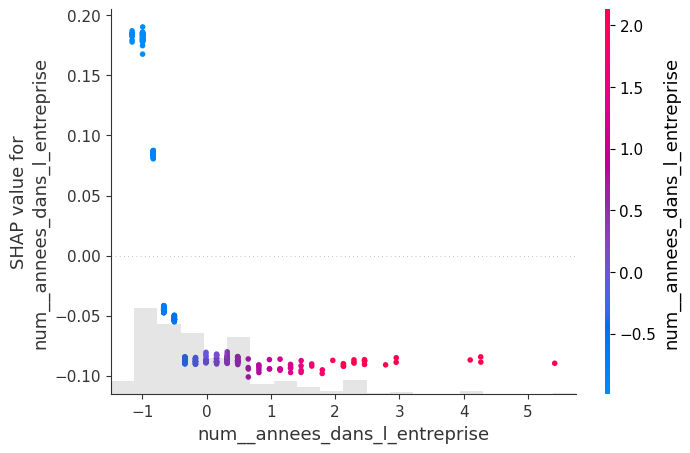

In [17]:
# Données transformées + noms
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names)

# Explainer + Explanation object
cat = best_model.named_steps['model']
explainer = shap.TreeExplainer(cat)
sv = explainer(X_df, check_additivity=False) 

# Scatter
shap.plots.scatter(
    sv[:, "num__annees_dans_l_entreprise"],
    color=sv[:, "num__annees_dans_l_entreprise"]
)

On voit une probabilité plus forte de départs pour ceux qui ont le moins d'ancienneté dans l'entreprise alors que les plus anciens ont plus de probabilité à rester.

### Recommandation 6 : Pour la feature importance locale, utilisez le Waterfall Plot. Choisissez quelques exemples issus des 2 classes.

### Attaquons nous à la feature locale
#### L'idée ici va être de regarder le comportement des features au cas par cas. Regardons plusieurs exemples.

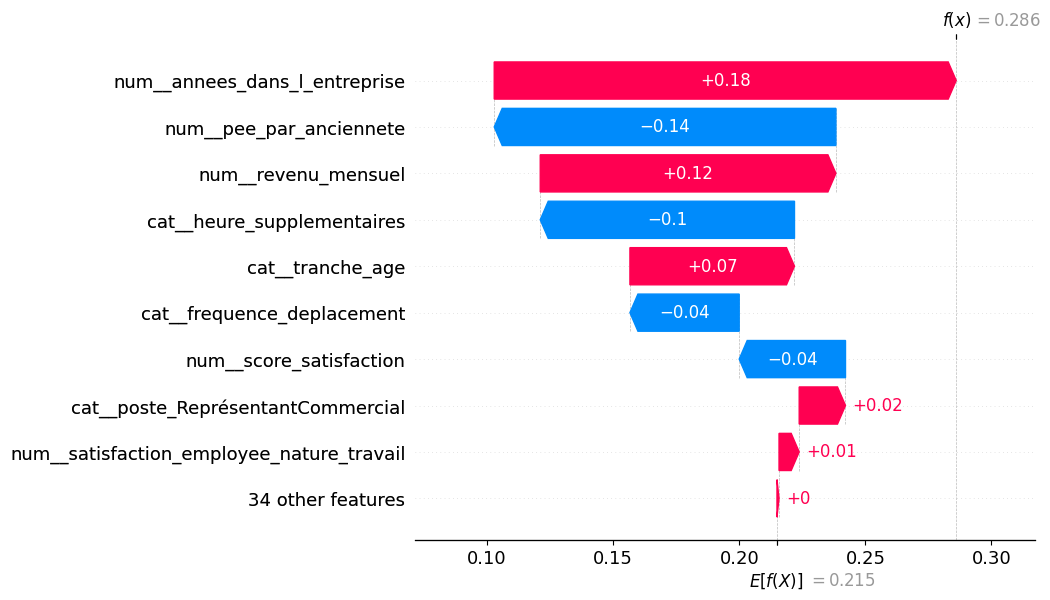

In [18]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Exemple local (waterfall sur le 1er individu)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
    feature_names=feature_names
)

On peut déjà noter la présence d'un indicateur de référence à 0.218 (moyenne de base) et les différentes features ont poussé la valeur prédictive à 0.317.
* Le nombre d'années dans l'entreprise pousse la prédiction vers la classe 1 ainsi que le revenu mensuel.
* Alors que nous voyons que la variable d'heures supplémentaires/celle de PEE ainsi que la fréquence de déplacement ont fait baisser le score de probabilité vers le bas.

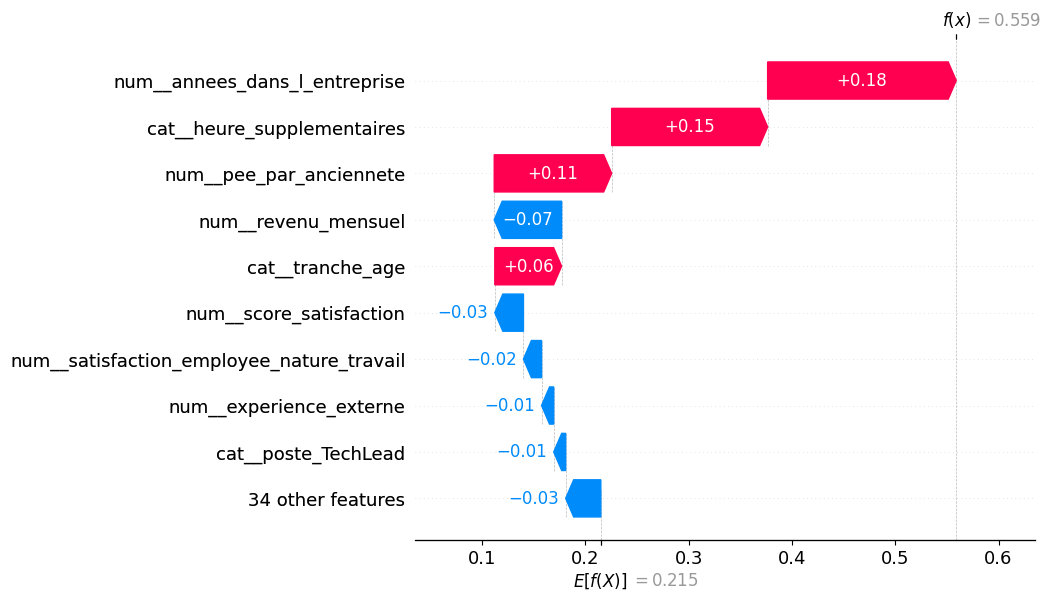

In [19]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Exemple local (waterfall sur le 17ième individu)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[18],
    feature_names=feature_names
)

La probabilité de base est de 0.218 et elle passe à 0.622 avec les features pour ce salarié.
* Les features déterminantes quant à son départ sont les heures supplémentaires, le nombre d'années dans l'entreprise, le PEE et la tranche d'âge. Par contre dans ce cas précis le revenu mensuel pousse le modèle vers le bas.